In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False

오토 인코더(Auto Encoder)

오토 인코더는 신경망의 한 종류로 입력 데이터를 코드(code)라고 부르는 은닉층을 인코딩하는 인코더(encoder) 부분과 인코딩된 코드를 다시 디코딩하는 디코더(Decoder)로 구성되어 있다. 인코딩은 원래 데이터를 차원 축소하는 것을 의미하고, 디코딩은 차원 축소된 데이터를 다시 원래 데이터로 복원하는 것을 의미한다.

<img src="./images/autoEncoder_1.png/" width="700"/>

오토 인코더의 시작은 차원 축소와 관련이 있는데 초기 오토 인코더는 주성분 분석과 같은 차원 축소를 위해 사용했지만, 현재는 데이터 생성 모형으로도 쓰인다.

오토 인코더 실습  
오토 인코더를 이용해 이미지 데이터의 노이즈를 없애본다.

In [2]:
# 일관된 결과값이 나오도록 random seed를 설정한다.
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
# 데이터 불러오기
from tensorflow.keras import datasets # 텐서플로우가 제공하는 데이터셋을 사용하기 위해 import 한다.
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data() # 손글씨 데이터셋을 피쳐, 타겟 데이터로 저장한다.

In [4]:
# 오리지널 데이터 확인
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


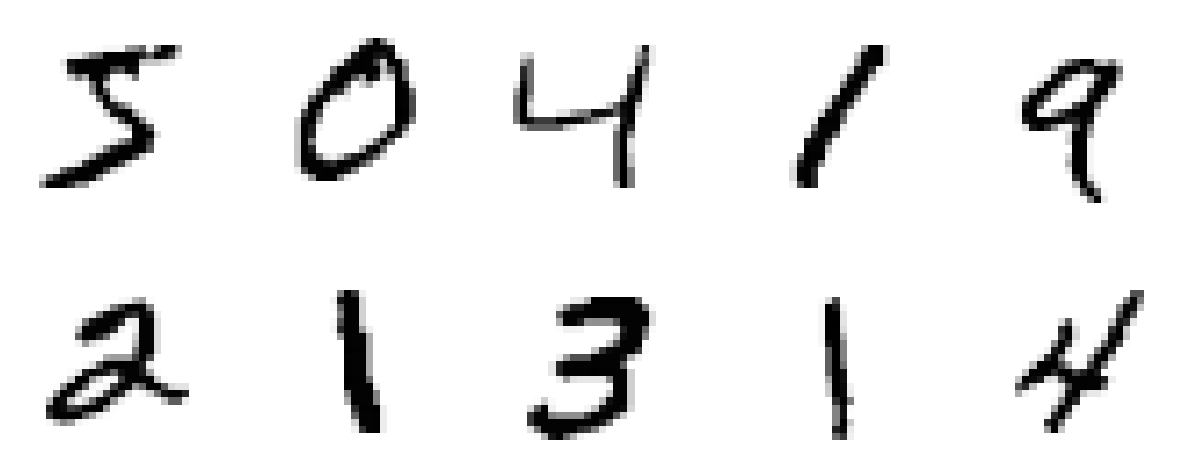

[5 0 4 1 9 2 1 3 1 4]


In [5]:
# 오리지널 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='Greys')
    plt.axis('off')
plt.show()
print(y_train[:10])

In [6]:
# 피쳐 데이터 스케일 조정
X_tn_re = X_train.reshape(60000, 28, 28, 1) # 트레이닝 피쳐 데이터의 차원을 바꿔준다.
X_tn = X_tn_re / 255 # 이미지 픽셀값은 0에서 255 사이에 있으므로 최대값이 1이 되도록 조정한다.
print(X_train.shape, X_tn_re.shape, X_tn.shape)
X_te_re = X_test.reshape(10000, 28, 28, 1) # 테스트 피쳐 데이터의 차원을 바꿔준다.
X_te = X_te_re / 255
print(X_test.shape, X_te_re.shape, X_te.shape)

(60000, 28, 28) (60000, 28, 28, 1) (60000, 28, 28, 1)
(10000, 28, 28) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [7]:
# 노이즈 피쳐 데이터를 만든다.
# mnist 데이터셋에서 노이즈를 따로 제공하지 않으므로, 오리지널 트레이닝 데이터에 랜덤값을 더해서 직접 
# 노이즈 데이터를 생성한다.
# 랜덤값은 -1부터 1 사이의 값을 가지며, 노이즈 배열의 크기는 트레이닝 데이터의 차원과 일치시켜 생성한다.
X_tn_noise = X_tn + np.random.uniform(-1, 1, size=X_tn.shape)
X_te_noise = X_te + np.random.uniform(-1, 1, size=X_te.shape)

In [8]:
# 노이즈 데이터 스케일링
# 노이즈 데이터를 생성하는 과정에서 픽셀값이 0보다 작아지거나 1보다 커질 가능성이 있어서 스케일을 조정한다.
# 넘파이의 clip() 메소드를 사용하면 값의 범위를 a_min 속성과 a_max 속성값 사이의 값으로 조정할 수 있다.
# a_min=0으로 지정하면 0보다 작은 데이터는 전부 0이 되고 a_max=1로 지정하면 1보다 큰 데이터는 전부 1이 된다.
X_tn_ns = np.clip(X_tn_noise, a_min=0, a_max=1)
X_te_ns = np.clip(X_te_noise, a_min=0, a_max=1)

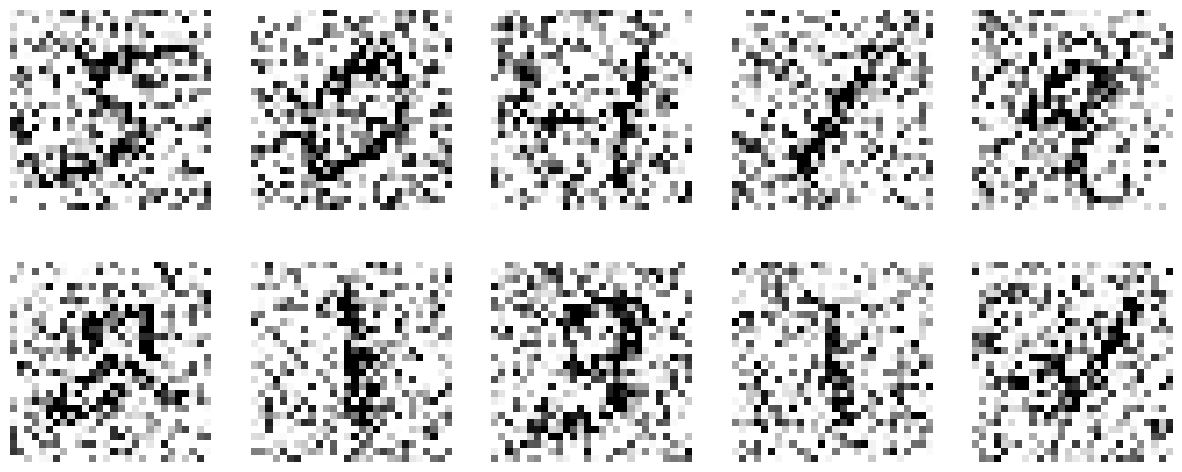

[5 0 4 1 9 2 1 3 1 4]


In [9]:
# 노이즈 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_tn_ns[i].reshape((28, 28)), cmap='Greys')
    plt.axis('off')
plt.show()
print(y_train[:10])

오토 인코더 신경망 모델을 만든다.

In [10]:
# 함수형 API를 사용한 오토 인코더 신경망 모델 생성에 필요한 라이브러리 import
from tensorflow.keras.models import Model # 함수형 API 신경망을 생성하기 위해 import 한다.
from tensorflow.keras.layers import Input # 신경망에 추가할 입력 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import Conv2D # 신경망에 추가할 합성곱 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import MaxPool2D # 신경망에 추가할 맥스 풀링 layer를 생성하기 위해 import 한다.
from tensorflow.keras.layers import Activation # 신경망에 활성화 함수 layer를 생성하기 위해 import 한다.
# 다운샘플링(Down-sampling)은 Image 크기를 줄여가며 특징을 추출하는 과정이고 업샘플링(Up-sampling)은
# 원래 Image 크기로 복원하는 과정이다.
from tensorflow.keras.layers import UpSampling2D # 신경망에 업샘플링 layer를 생성하기 위해 import 한다.

In [11]:
# 인코더 모델
# 인코더 모델에 추가할 input layer를 만든다.
# input layer의 Output Shape은 shape 속성값을 따른다. [(None, 28, 28, 1)]
# input layer로 들어오는 데이터가 없기 때문에 Param 0이다.
input_layer1 = Input(shape=(28, 28, 1))
# 인코더 모델에 추가할 Conv2D layer를 만든다.
# padding 속성을 same로 지정했기 때문에 제로 패딩이 들어가서 Output Shape의 이미지 차원은 변경되지 않고
# 출력 차원은 filters 속성값을 따른다. (None, 28, 28, 20)
# Conv2D layer의 Param은 kernel_size * 입력 채널 크기 * filters + filters마다 1개씩의 바이어스로 결정된다.
# kernel_size(5 * 5) * 입력 채널 크기(1) * filters(20) + filters마다 1개씩의 바이어스(20) = 520
x1 = Conv2D(filters=20, kernel_size=(5, 5), padding='same')(input_layer1)
# Activation layer는 Output Shape은 변화가 없고 Param은 0이다.
x1 = Activation(activation='relu')(x1)
# 인코더 모델에 추가할 output layer를 만든다.
# MaxPool2D layer의 Output Shape은 입력 데이터의 차원수 / pool_size로 결정된다. 28 / 2 = 12, (None, 14, 14, 20)
# MaxPool2D layer는 Param이 없으므로 0이다.
output_layer1 = MaxPool2D(pool_size=(2, 2), padding='same')(x1)
# 인코더 모델을 만든다.
encoder = Model(input_layer1, output_layer1)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 activation (Activation)     (None, 28, 28, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 인코더의 출력 차원 확인
print(output_layer1.shape)
print(output_layer1.shape[0])
print(output_layer1.shape[1])
print(output_layer1.shape[2])
print(output_layer1.shape[3])
print(output_layer1.shape[1:4]) # 디코더 모델의 입력 데이터 크기(shape 속성값)로 적용된다. (14, 14, 20)

(None, 14, 14, 20)
None
14
14
20
(14, 14, 20)


In [13]:
# 디코더 모델
# 디코더 모델에 추가할 input layer를 만든다.
# 디코더 모델의 input layer 입력되는 데이터 크기는 인코더 모델의 출력 크기와 같다.
# input layer의 Output Shape은 shape 속성값을 따른다. [(None, 14, 14, 20)]
# input layer로 들어오는 데이터가 없기 때문에 Param 0이다.
input_layer2 = Input(shape=output_layer1.shape[1:4])
# 디코더 모델에 추가할 Conv2D layer를 만든다.
# padding 속성을 same로 지정했기 때문에 제로 패딩이 들어가서 Output Shape의 이미지 차원은 변경되지 않고
# 출력 차원은 filters 속성값을 따른다. (None, 14, 14, 10)
# Conv2D layer의 Param은 kernel_size * 입력 채널 크기 * filters + filters마다 1개씩의 바이어스로 결정된다.
# kernel_size(5 * 5) * 입력 채널 크기(20) * filters(10) + filters마다 1개씩의 바이어스(10) = 5010
x2 = Conv2D(filters=10, kernel_size=(5, 5), padding='same')(input_layer2)
# Activation layer는 Output Shape은 변화가 없고 Param은 0이다.
x2 = Activation(activation='relu')(x2)
# 줄어들었던 차원을 다시 높여주기 위해 UpSampling2D layer를 만든다.
# UpSampling2D layer의 Output Shape은 이미지가 압축되기전 차원으로 변환된다. (None, 28, 28, 10)
# UpSampling2D layer는 Param이 없으므로 0이다.
x2 = UpSampling2D()(x2)
# 디코더 모델에 추가할 output layer를 만든다.
# 최종 출력 채널의 개수는 최초 입력 이미지의 채널 수와 같아야 하므로 1로 설정한다.
# padding 속성을 same로 지정했기 때문에 제로 패딩이 들어가서 Output Shape의 이미지 차원은 변경되지 않고
# 출력 차원은 filters 속성값을 따른다. (None, 28, 28, 1)
# Conv2D layer의 Param은 kernel_size * 입력 채널 크기 * filters + filters마다 1개씩의 바이어스로 결정된다.
# kernel_size(5 * 5) * 입력 채널 크기(10) * filters(1) + filters마다 1개씩의 바이어스(1) = 251
x2 = Conv2D(filters=1, kernel_size=(5, 5), padding='same')(x2)
# Activation layer는 Output Shape은 변화가 없고 Param은 0이다.
output_layer2 = Activation(activation='relu')(x2)
decoder = Model(input_layer2, output_layer2)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14, 14, 20)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 10)        5010      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 10)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         251       
                                                                 
 activation_2 (Activation)   (None, 28, 28, 1)         0         
                                                           

In [14]:
# 오토 인코더 모델 생성
# 오토 인코더는 최초 입력값을 인코더에 먼저 넣고, 그 결과로 나온 출력을 다시 디코더에 넣은 결과이다.
# 오토 인코더 모델에 추가할 input layer를 만든다.
input_auto = Input(shape=(28, 28, 1))
# 오토 인코더 모델에 추가할 output layer를 만든다.
output_auto = decoder(encoder(input_auto))
# 오토 인코더 모델을 만든다.
auto_encoder = Model(input_auto, output_auto)
auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 14, 14, 20)        520       
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         5261      
                                                                 
Total params: 5,781
Trainable params: 5,781
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 모델 컴파일
auto_encoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [16]:
# 신경망 학습
# 노이즈가 추가된 트레이닝 피쳐 데이터(X_tn_ns)와 노이즈가 없는 트레이닝 데이터(X_tn)를 지정하고 
# epochs 속성에 epoch와 batch_size 속성에 batch_size를 지정한다. epochs가 커질 수록 정확도는 올라간다.
hist = auto_encoder.fit(X_tn_ns, X_tn, epochs=10, batch_size=100)

Epoch 1/10
600/600 [==============================] - 65s 106ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 2/10
600/600 [==============================] - 54s 90ms/step - loss: 0.0224 - mean_squared_error: 0.0224
Epoch 3/10
600/600 [==============================] - 55s 91ms/step - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 4/10
600/600 [==============================] - 55s 91ms/step - loss: 0.0200 - mean_squared_error: 0.0200
Epoch 5/10
600/600 [==============================] - 55s 91ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 6/10
600/600 [==============================] - 54s 91ms/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 7/10
600/600 [==============================] - 55s 91ms/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 8/10
600/600 [==============================] - 55s 91ms/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 9/10
600/600 [==============================] - 55s 91ms/step - loss: 0.0157 - mean_squared_error

In [17]:
# 학습된 모델 예측
X_pred =  auto_encoder.predict(X_tn_ns)

1875/1875 [==============================] - 20s 11ms/step


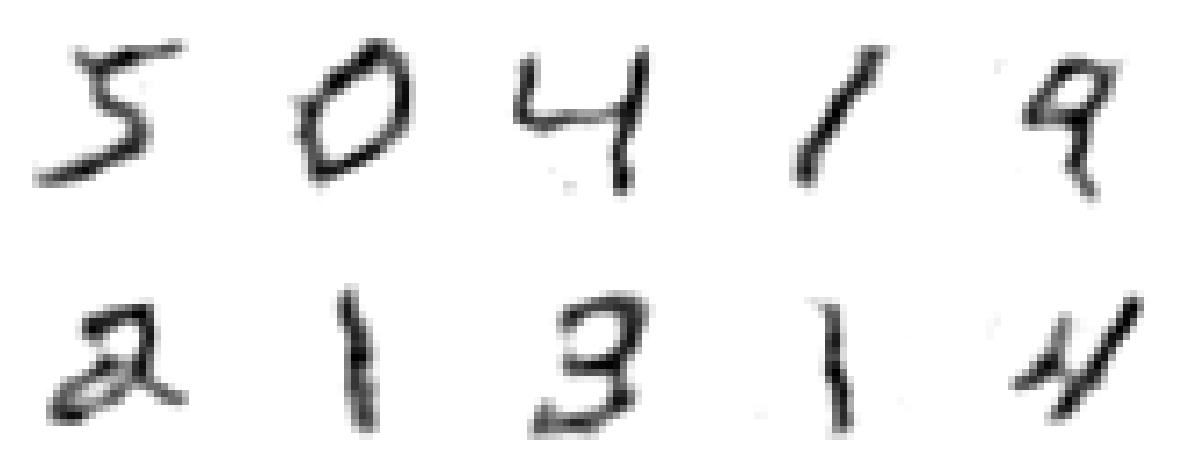

[5 0 4 1 9 2 1 3 1 4]


In [18]:
# 오토 인코딩 모델로 학습한 노이즈 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_pred[i].reshape((28, 28)), cmap='Greys')
    plt.axis('off')
plt.show()
print(y_train[:10])